# Direct Detection examples using the Fisher Information

Here we implement limit calculations for both CRESST-III and Xenon-nT using the Fisher Information Formalism. We individually estimate the sensitivity of the different experiments, investigate the parameter spaces using Information Geometry, and describe how the information flux scales with observation time. Next we present the simplicity of the additive nature of the Fisher formalism by showing the complementarity between the two experiments

## CRESST-III

We start with some standard imports

In [4]:
from __future__ import division
import healpy as hp
import numpy as np
import pylab as plt
import swordfish as sf
from scipy.interpolate import interp1d
from scipy.integrate import quad
from math import cos, sin
from scipy.special import erf
from scipy.constants import c
from matplotlib import rc
from scipy.interpolate import UnivariateSpline
rc('font', family='serif', serif='cmr10', size=12)
rc('text', usetex=True)

c_kms = c*1.e-3 # in km s^-1
g2 = 1.e-18
m_med = 10. # MeV

Now we define the signal component as,
$$ \frac{dR}{dE_R} = \frac{\rho_0\xi_T}{2\pi m_{DM}} \frac{g^2 F_T^2(E_{R})}{(2m_TE_{R} + m^2_{med})^2}\eta(v_{min}(E_R))$$

where $E_R$ is the recoil energy, $\rho_0$ is the dark matter density at earth (which we take to be $0.3 GeV cm^{-3}$, $m_{DM}$ is the dark matter mass, $m_{med}$ is the mediator mass, $F_T^2(E_{R})$ is the recoil form factor, and $m_T$ is the mass of the target isotope. The signal is spread out due to the finite energy resolution of the instrument. Following 1707.08571v1 we assume the resolution fo be described by a Gaussian distribution with an energy dependent standard deviation $\sigma(E_R)$. The probability of a scattering signal occurring in a given interval is then,

$$p(E_R,E_1,E_2) = \frac{1}{2}\left[erf\left(\frac{E_2-E_R}{\sqrt{2}\sigma(E_R)}\right) - \left(\frac{E_1-E_R}{\sqrt{2}\sigma(E_R)}\right)\right]~,$$

which we can then use to calculate the number of signal events in a given bin as,

$$N(E_1,E_2) = \sum_T \int p_T(E_R,E_1,E_2)\frac{dR_T}{dE_R} dE_R$$

We implement these equations here

In [5]:
rho_0 = 0.3*1.e3  # MeV/cm3
# Define energy range in MeV
E = np.linspace(0.1*1e-3, 2.*1e-3, num=19) 
Ewidth = E[1]-E[0]
Emeans = E[0:-1]+Ewidth/2.

def eta_F():
    """Returns an interpolated integral over the velocity distribution, taken to be Maxwellian"""
    v, gave = np.loadtxt("DD_files/gave.dat", unpack=True, dtype=float)
    f = interp1d(v, gave, bounds_error=False, fill_value=0.0) # s km^-1
    return f

def dRdE(E_R, m_DM, A, xi_T):
    """Return differential recoil rate in 1/s/MeV/kg."""
    # g is the parameter we wish to set a limit on so is left out
    # Form factor taken from eq4.4 of http://pa.brown.edu/articles/Lewin_Smith_DM_Review.pdf
    m_T = A*931.5 # MeV
    muT = m_DM*m_T/(m_DM + m_T) # unitless
    rn = A**(1/3) * 1/197. # fm --> MeV^-1
    F_T = lambda q: np.sqrt(np.exp(-((q*rn)**2.)/3.))
    vmin = lambda E_R: np.sqrt(m_T*E_R/2/(muT**2.))
    eta = eta_F()
    q = np.sqrt(2*m_T*E_R)
    signal = (A**2)*F_T(q)**2*eta(vmin(E_R)*c_kms)*rho_0*xi_T*g2/2./np.pi/m_DM/((q**2+m_med**2)**2)
    conversion = 1.96311325e24 # MeV^-4 cm^-3 s km^-1 hbar^2 c^6 --> MeV^-1 s^-1 kg^-1
    signal *= conversion 
    return signal

def ScatterProb(E_R, E1, E2):
    """CRESST definition, energy resoultion is set by a Gaussian at 20 eV"""
    var = 20.*1.e-6 # MeV
    prob = (erf((E2-E_R)/np.sqrt(2)/var) - erf((E1-E_R)/np.sqrt(2)/var))/2.
    return prob

We can now use these definitions to calculate the signal component given a specific dark matter mass

In [6]:
def CRESST_sig(m_DM):
    m_DM *= 1.e3 # conversion to MeV
    A_Ca = 40.78
    A_W = 183.84
    A_O = 15.9994
    xi_T_Ca = 0.1392
    xi_T_W = 0.63852
    xi_T_O = 0.2222
    As = [A_Ca, A_W, A_O]
    xi_Ts = [xi_T_Ca, xi_T_W, xi_T_O]
    
    sig = np.zeros_like(Emeans)
    for k in range(3):
        sig_temp = np.zeros_like(Emeans)
        A = As[k]
        xi_T = xi_Ts[k]
        m_T = A*931.5 # MeV
        muT = m_DM*m_T/(m_DM + m_T) # unitless
        Eth = 100*1e-6 # threshold energy MeV
        Vesc = 544./c_kms
        Vobs = 232./c_kms
        qmin = np.sqrt(2.*m_T*Eth)  # MeV
        qmax = 2.*muT*(Vesc + Vobs)  # MeV
        E_Rmin = qmin**2./2./m_T
        if E_Rmin < 60.e-6:
            E_Rmin = 60.e-6
        E_Rmax = qmax**2./2./m_T

        if qmin > qmax:
            print "Skip m_DM [GeV]", m_DM*1e-3
            continue

        sig_dif = lambda ER, x1, x2, m_DM, Atmp, xi_Ttmp: ScatterProb(ER, x1, x2)*dRdE(ER,m_DM,Atmp,xi_Ttmp)

        for i in range(len(Emeans)):
            sig_temp[i] = quad(sig_dif, E_Rmin, E_Rmax, args=(E[i],E[i+1],m_DM,A,xi_T))[0]

        sig += sig_temp

    if np.count_nonzero(sig) == 0:
        print "No signal at m_DM [GeV]", m_DM*1e-3
        return np.zeros_like(sig)
    
    return sig

The final component is to define the background and any systematic uncertainties we wish to describe. Initially we will take the background as fixed at $3.5 \times 10^{-2} keV^{-1} kg^{-1} day^{-1}$ and $1000~ kg~ days$ of observation. We can now calculate an exclusion limit using a swordfish object

In [7]:
def UL_CRESST(m_DM):
        sig = CRESST_sig(m_DM)
        bkg = np.ones_like(sig)*3.5e-2*(Ewidth*1e3)/(3600.*24) # kg^-1 day^-1 --> kg^-1 s^-1
        obsT = np.ones_like(sig)*24*3600*1000
        if np.count_nonzero(sig) == 0:            
            return None
        else:
            systematics = None
            flux = [sig, bkg]
            noise = flux[1]
            SF = sf.Swordfish(flux, noise, systematics, obsT, verbose=False)

            # Calculate upper limits with effective counts method
            EC = sf.EffectiveCounts(SF)
            UL = EC.upperlimit(0.1, 0)
            return UL

# Xenon1T

Lets now also implement a simple 1 bin example computation for Xenon 1T. We now take the background from 1705.06655 in the reference region, where the background is expected to be low. For the signal we take the effeciency curve for the entire search region and assume that 47.5% of the signal ends up in the reference band

In [94]:
# Load in efficiency
# Black curve in Fig. 1 of 1705.06655

eff1, eff2 = np.loadtxt("Swordfish_Xenon1T/Efficiency-1705.06655.txt", unpack=True)
efficiency = UnivariateSpline(eff1, eff2, ext="zeros", k=1, s=0)


# Load in table of values of S1 vs ER
# Extracted from bottom panel of Fig. 2 of 1705.06655
# Corresponds to S1 values where the grey nuclear recoil
# contours cross the solid red nuclear recoil median line
S1_vals, E_vals = np.loadtxt("Swordfish_Xenon1T/S1vsER.txt", unpack=True)

# Interpolation for the recoil energy as a function of S1
# and the derivative
CalcER = UnivariateSpline(S1_vals, E_vals, k=1, s=0)

# Note that the numerical derivatives might give you a rate
# with some steps in (as the slope changes between the
# interpolated points). If you want something smoother,
# you can increase k and s in the UnivariateSpline function.
dERdS1 = CalcER.derivative()

# Recoil distribution as a function of S1
# taking into account the efficiency and change
# of variables ER -> S1
def dRdS1(S1, m_DM):
    A_Xe = 54. #FIXME: Change to Xenon values
    xi_T_Xe = 1.0
    ER_keV = CalcER(S1)
    ER_MeV = ER_keV*1.e-3
    #Factor of 0.475 comes from the fact that
    #the reference region should contain about
    #47.5% of nuclear recoils (between median and 2sigma lines)
    return 0.475*efficiency(ER_keV)*dRdE(ER_MeV,m_DM,A_Xe,xi_T_Xe)*dERdS1(S1)

In [95]:
def Efficiency():
    """Returns an interpolated value of the efficiency from Fig 1 in 1705.06655"""
    ER, eff = np.loadtxt("DD_files/Efficiency.txt", unpack=True, dtype=float)
    ER *= 1.e-3 # KeV --> MeV
    f = interp1d(ER, eff, bounds_error=False, fill_value=0.0)
    return f

In [96]:
# We are now working in distributions as a function of s1
s1 = np.linspace(3,70,num=30)
s1width = s1[1]-s1[0]
s1means = s1[0:-1]+s1width/2.
bkgs = ['acc','Anom','ElectronRecoil','n','Neutrino','Wall']

def load_bkgs():
    b = dict()
    for i in range(len(bkgs)):
        S1, temp = np.loadtxt("DD_files/" + bkgs[i] + ".txt", unpack=True)
        interp = interp1d(S1, temp, bounds_error=False, fill_value=0.0)
        b[bkgs[i]] = interp(s1means)
    return b
    
    
def XenonIT_sig(m_DM):
    m_DM *= 1.e3 # conversion to MeV
    A_Xe = 54. #FIXME: Change to Xenon values
    xi_T_Xe = 1.0
    Eff = Efficiency()
 
    m_T = A_Xe*931.5 # MeV
    muT = m_DM*m_T/(m_DM + m_T) # unitless
    Eth = 100*1e-6 # threshold energy MeV
    Vesc = 544./c_kms
    Vobs = 232./c_kms
    qmin = np.sqrt(2.*m_T*Eth)  # MeV
    qmax = 2.*muT*(Vesc + Vobs)  # MeV
    E_Rmin = qmin**2./2./m_T
    if E_Rmin < 60.e-6:
        E_Rmin = 60.e-6
    E_Rmax = qmax**2./2./m_T

    if qmin > qmax:
        print "Skip m_DM [GeV]", m_DM*1e-3
        return 0.0    
    
    sig = dRdS1(s1means,m_DM)*s1width

    if np.count_nonzero(sig) == 0:
        print "No signal at m_DM [GeV]", m_DM*1e-3
        return 0.0
    
    return sig

In [102]:
def UL_Xenon(m_DM):
        sig = XenonIT_sig(m_DM)
        # bkg = np.ones_like(sig)*0.36/3600./24/35636. # kg^-1 day^-1 --> kg^-1 s^-1
        b_dict = load_bkgs()
        obsT = np.ones_like(sig)*24.*3600.*35636.
        if np.count_nonzero(sig) == 0:            
            return None
        else:
            systematics = None

            flux = [sig, b_dict[bkgs[0]], b_dict[bkgs[1]], b_dict[bkgs[2]],
                    b_dict[bkgs[3]], b_dict[bkgs[4]], b_dict[bkgs[5]]]
            noise = flux[1]+flux[2]+flux[3]+flux[4]+flux[5]+flux[6]
            SF = sf.Swordfish(flux, noise, systematics, obsT, verbose=False)

            # Calculate upper limits with effective counts method
            EC = sf.EffectiveCounts(SF)
            UL = EC.upperlimit(0.1, 0)
            return UL

No signal at m_DM [GeV] 3.16227766017
No signal at m_DM [GeV] 3.5938136638
No signal at m_DM [GeV] 4.08423865267


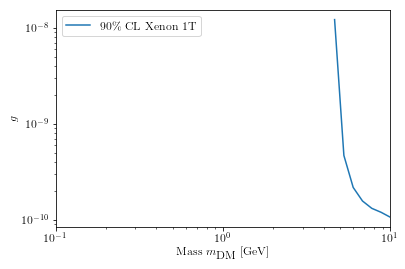

In [107]:
mlist = np.logspace(0.5, 1, 10)
# ULlist_CRESST = []
#print np.sqrt(UL_CRESST(10)*g2)
ULlist_Xenon = []
# for i, m in enumerate(mlist):
#    UL = UL_CRESST(m)
#    if UL is None:
#        ULlist_CRESST.append(0.)
#    else:
#        ULlist_CRESST.append(UL*g2)

for i, m in enumerate(mlist):
    UL = UL_Xenon(m)
    if UL is None:
        ULlist_Xenon.append(0.)
    else:
        ULlist_Xenon.append(UL*g2)

# plt.loglog(mlist, np.sqrt(ULlist_CRESST), label="90% CL CRESST-III")
plt.loglog(mlist, np.sqrt(ULlist_Xenon), label="90\% CL Xenon 1T")
plt.legend()
plt.xlabel(r"Mass $m_{\textrm{DM}}$ [GeV]")
plt.ylabel(r"$g$")
plt.xlim(0.1,10)
plt.show()